In [1]:
import itertools
import os

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from softcvi_validation.utils import get_palette
from softcvi_validation.tasks.available_tasks import get_available_tasks
from spyrox.utils import get_abspath_project_root
import jax.random as jr
from spyrox.tasks.sirsde_with_covariates import get_task
import equinox as eqx

os.chdir(get_abspath_project_root())
plt.style.use('./plots/style.mplstyle')
palette = get_palette()
palette.pop("SoftCVI(a=0)")

tasks = get_available_tasks()
method_names = [k for k in palette.keys() if k!="True"]

box_kwargs = {
    "showfliers": False,
    "palette": palette,
    "saturation": 1,
    "linewidth": 0.6,
}

num_rounds = [1, 2, 4]
seeds = range(1,51)
budget=60000

handles = [
    mpatches.Patch(facecolor=v, label=k.replace("a=", r"$\alpha$="), edgecolor="black")
    for k, v in palette.items() if k in method_names
]

In [2]:

log_prob_true_data = {
    "method_name": [],
    "log_prob_true": [],
    "num_rounds": [],
    "seed": [],
}

coverage_data = {
    "method_name": [],
    "coverage_prob": [],
    "num_rounds": [],
}


coverage_results = {
    method_name: {} for method_name in method_names 
}

for n_rounds, seed, method in itertools.product(num_rounds, seeds, method_names):

    cov_probs = []
    
    file = f"results/metrics/{method}_seed={seed}_num_rounds={n_rounds}_budget={budget}.npz"

    try:    
        metrics = dict(np.load(file))
    except FileNotFoundError:
        print(f"Not found: {file}")
        continue
     
    log_prob_true_data["method_name"].append(method)
    log_prob_true_data["log_prob_true"].append(metrics["log_prob_true"].item())
    log_prob_true_data["num_rounds"].append(n_rounds)
    log_prob_true_data["seed"].append(seed)

    coverage_data["method_name"].append(method)
    coverage_data["coverage_prob"].append(metrics["coverage_prob"].item())
    coverage_data["num_rounds"].append(n_rounds)


Not found: results/metrics/ELBO_seed=38_num_rounds=2_budget=60000.npz
Not found: results/metrics/ELBO_seed=39_num_rounds=2_budget=60000.npz
Not found: results/metrics/ELBO_seed=40_num_rounds=2_budget=60000.npz
Not found: results/metrics/ELBO_seed=41_num_rounds=2_budget=60000.npz


/tmp/ipykernel_102904/3038429929.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


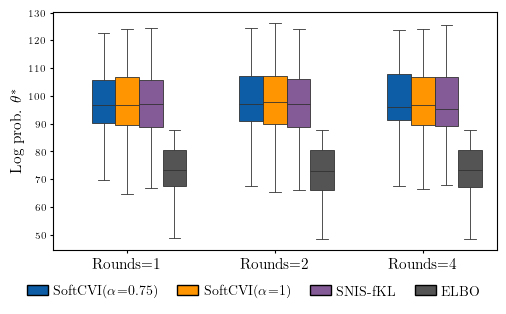

In [3]:
df = pd.DataFrame(log_prob_true_data)

total_fig = plt.figure(figsize=(plt.rcParams["figure.figsize"][0]*0.9, 3), layout="constrained")
fig, legend_fig = total_fig.subfigures(nrows=2, height_ratios=[10, 1])

ax = fig.subplots()

sns.boxplot(
    data=df,
    x="num_rounds",
    y="log_prob_true",
    hue="method_name",
    hue_order=palette.keys(),
    ax=ax,
    **box_kwargs,
)

ax.set_xticklabels(
    [f"Rounds={r.get_text()}" for r in ax.get_xticklabels()],
    )

ax.xaxis.set_tick_params(labelsize=11)
ax.set_ylabel(r"Log prob. $\theta^*$", size=11)
ax.set_xlabel("")
legend_fig.legend(handles=handles, ncols=len(method_names))
ax.legend_.remove()
#total_fig.savefig("sirsde_with_covariates_simbudget=100000.pdf")

In [4]:
# Rank best performing number of rounds for each method:
results = []
grouped = df.groupby(["method_name", "seed"])

for (method, seed), group in grouped:
    max_num_rounds = group.loc[group["log_prob_true"].idxmax(), "num_rounds"]
    results.append({"method_name": method, "num_rounds": max_num_rounds})

highest_prob_df = pd.DataFrame(results)
frequency_table = highest_prob_df.groupby(["method_name", "num_rounds"]).size().reset_index(name="frequency")
print(frequency_table)


        method_name  num_rounds  frequency
0              ELBO           1         19
1              ELBO           2         14
2              ELBO           4         17
3          SNIS-fKL           1         15
4          SNIS-fKL           2         18
5          SNIS-fKL           4         17
6   SoftCVI(a=0.75)           1         10
7   SoftCVI(a=0.75)           2         17
8   SoftCVI(a=0.75)           4         23
9      SoftCVI(a=1)           1          9
10     SoftCVI(a=1)           2         20
11     SoftCVI(a=1)           4         21


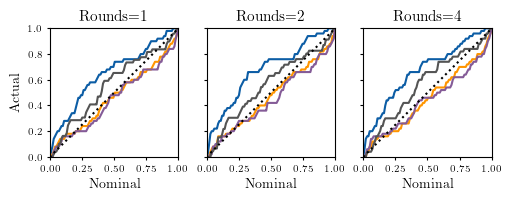

In [5]:
coverage_df = pd.DataFrame(coverage_data)

fig = plt.figure(constrained_layout=True, figsize=(5, 3))

axes = fig.subplots(
    ncols=len(num_rounds),
    sharey=True,    
)

# Ensure axes is always iterable, even if there's only one row
if len(num_rounds) == 1:
    axes = [axes]

# Iterate over rounds to plot coverage
for r, ax in zip(num_rounds, axes, strict=True):
    for method in method_names:

        # Filter coverage data for the specific round and method
        probs = jnp.asarray(
            coverage_df[
                (coverage_df["num_rounds"] == r) & (coverage_df["method_name"] == method)
            ]["coverage_prob"],
        )

        # Compute nominal frequencies and actual coverage
        nominal = jnp.linspace(0, 1, 100)
        coverage_freq = jnp.array([(probs >= 1 - nom).mean() for nom in nominal])

        # Plot coverage curve for the method
        ax.plot(
            nominal,
            coverage_freq,
            label=method,
            color=palette[method],
            )

    # Add diagonal line
    ax.plot(nominal, nominal, linestyle=":", color="black")

    # Set axis labels and limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"Rounds={r}")


axes[0].set_ylabel("Actual")

# Set the x-axis label for the last subplot
[ax.set_xlabel("Nominal") for ax in axes]
[ax.set_box_aspect(1) for ax in axes]

# Add a legend to the first subplot
handles_and_labels = axes[0].get_legend_handles_labels()



In [6]:
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
from jax.typing import ArrayLike


def pairplot_dictionary(
    data: dict[str, ArrayLike],
    *,
    column_names: list[str] | None = None,
    filter_outliers: float = 3,
    shuffle: bool = True,
    equalize_points: bool = True,
    s: float = 10,
    **kwargs,
):
    """Generate a poirplot from a dictionary of arrays.

    We add special handling of one-dimensional arrays, by adding vertical lines on
    the density plots corresponding to the points, and by making the point larger.
    This is because we assume the single point has some significance (ground truth,
    or observations).

    Args:
        data: Dictionary of arrays.
        column_names: Column names corresponding to array columns.
        filter_outliers: Filter outliers outside the interval
            ``[Q1–filter_outliers*IQR, Q3+filter_outliers*IQR]``. Defaults to 3.
        shuffle: Wheter to shuffle points, or to overlay them in the order passed.
            Defaults to True.
        equalize_points: Whether to equalize the number of points in each 2D dataset,
            by first N points from each dataset, where N is the smallest dataset passed.
            Defaults to True.
        s: The point size.
    """
    data_2d = {k: np.asarray(arr) for k, arr in data.items() if arr.ndim == 2}
    smallest = min(arr.shape[0] for arr in data_2d.values())
    dfs = []

    if column_names is None:
        column_names = range(list(data_2d.values())[0].shape[1])

    for k, arr in data_2d.items():
        arr = _filter_outliers(arr, filter_outliers)

        if equalize_points:
            arr = arr[:smallest]

        df_i = pd.DataFrame(arr, columns=column_names)
        df_i["source"] = k
        df_i["size"] = s
        dfs.append(df_i)

    df = pd.concat(dfs)

    if shuffle:
        df = df.sample(frac=1)

    data_1d = {k: np.array(arr) for k, arr in data.items() if arr.ndim == 1}

    dfs = []
    for k, arr in data_1d.items():
        arr = arr[None, :]
        df_i = pd.DataFrame(arr, columns=column_names)
        df_i["source"] = k
        df_i["size"] = 1000 * s
        dfs.append(df_i)

    df = pd.concat([df, *dfs])
    df = df.reset_index(drop=True)
    sizes = np.asarray(df.pop("size"))

    pairplot = sns.pairplot(
        df,
        hue="source",
        plot_kws={"size": sizes, "edgecolor": "none", "rasterized": True, "alpha": 0.8},
        diag_kws={"common_norm": False},
        corner=True,
        hue_order=data.keys(),
        **kwargs,
    )

    for i, (k, arr) in enumerate(data_1d.items()):
        label_index = np.argwhere([k == data_key for data_key in data.keys()]).item()
        color = pairplot.legend.legend_handles[label_index].get_markerfacecolor()
        for i, ax in enumerate(np.diag(pairplot.axes)):
            y_lim = ax.get_ylim()
            ax.axvline(x=arr[i], color=color, ymin=0, ymax=y_lim[1])

    pairplot._legend.remove()
    return pairplot


def _filter_outliers(data, n):
    q1 = jnp.nanpercentile(data, 25, axis=0)
    q3 = jnp.nanpercentile(data, 75, axis=0)
    iqr = q3 - q1
    lower_bound = q1 - n * iqr
    upper_bound = q3 + n * iqr
    mask = jnp.logical_and(data >= lower_bound, data <= upper_bound).all(axis=1)
    return data[mask]


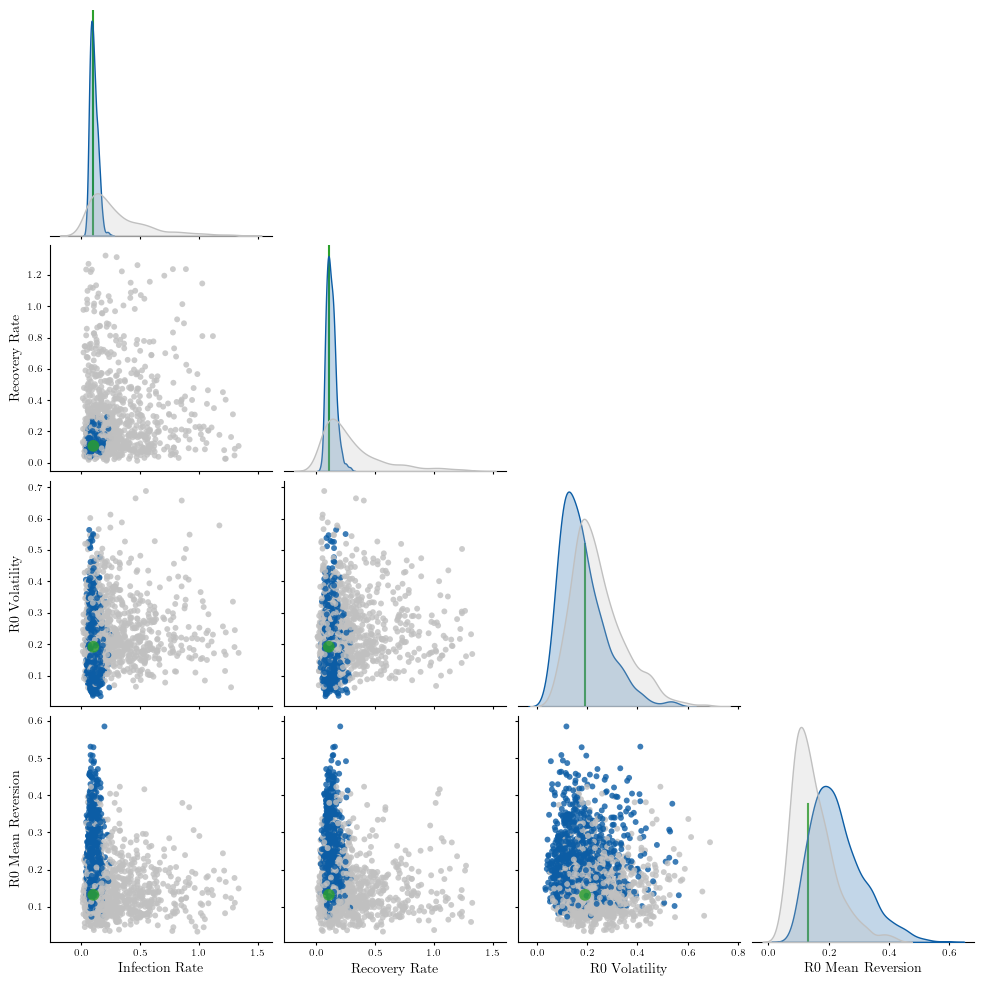

In [7]:
# Plot example posteriors
file = "SoftCVI(a=0.75)_seed=1_num_rounds=8"

samples = {
    "True": dict(jnp.load(f"results/samples/true_{file}.npz")),
    "Prior": dict(jnp.load(f"results/samples/joint_{file}.npz")),
    "Posterior": dict(jnp.load(f"results/samples/guide_{file}.npz")),
}
samples["Prior"] = {k: v for k, v in samples["Prior"].items() if k!="x"}

obs_idx = 0


pairplot = pairplot_dictionary(
    {
    "Prior": samples["Prior"]["z"][:, obs_idx],
    "Posterior": samples["Posterior"]["z"][:, obs_idx],
    "True": samples["True"]["z"][obs_idx],
    },
    column_names=[
        "Infection Rate",
        "Recovery Rate",
        "R0 Volatility",
        "R0 Mean Reversion",
        ],
        s=0.01,
    palette=["silver", palette["SoftCVI(a=0.75)"], "tab:green"],
)

# TODO add legend

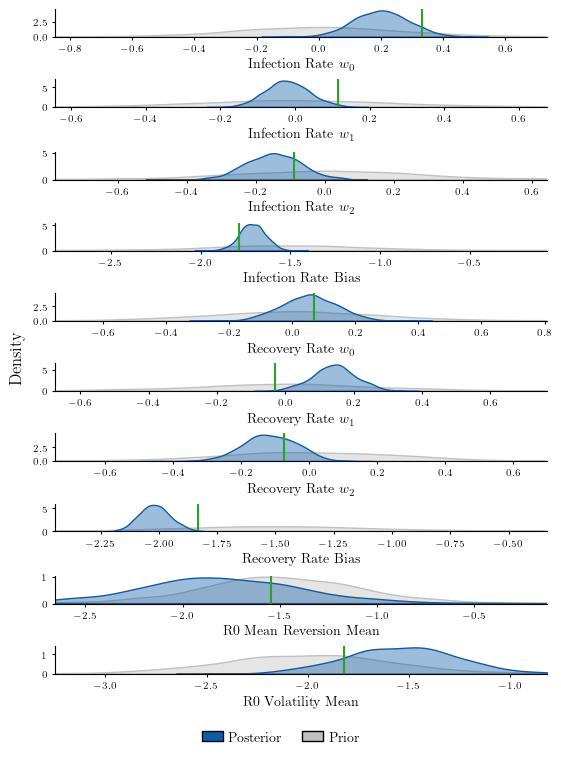

In [8]:
global_parameters = [
    "infection_rate_beta",
    "infection_rate_bias",
    "recovery_rate_beta",
    "recovery_rate_bias",
    "r0_mean_reversion_mean",
    "r0_volatility_mean",
]

# to avoid confusion with \beta being infection rate, we will use w (weights)

global_param_dim = 10

total_fig = plt.figure(
    layout='constrained',
    figsize=(plt.rcParams['figure.figsize'][0], 7.5),
    )

fig, legend_fig = total_fig.subfigures(nrows=2, ncols=1, height_ratios=[20, 1])
axes = fig.subplots(nrows=global_param_dim)

global_plot_palette = {
    "Posterior": palette["SoftCVI(a=0.75)"],
    "Prior": "silver",
}

idx=0
for param in global_parameters:
    
    prior_samps = samples["Prior"][param]

    posterior_samps = samples["Posterior"][param]
    true_samp = samples["True"][param]

    if prior_samps.ndim==2:
        for col_idx, (prior_col, posterior_col, true) in enumerate(zip(
            prior_samps.T,
            posterior_samps.T,
            true_samp,
            strict=True,
            )):
            sns.kdeplot(prior_col, ax=axes[idx],fill=True, alpha=0.4, color=global_plot_palette["Prior"])
            sns.kdeplot(posterior_col, ax=axes[idx],fill=True, alpha=0.4, color=global_plot_palette["Posterior"])
            axes[idx].axvline(true, color="tab:green")
            axes[idx].set_xlabel(
                param.replace("_", " ").title().replace("Beta", rf"$w_{col_idx}$"))
            axes[idx].set_xlim(*jnp.quantile(prior_col, jnp.array([0.001, 0.999])))
            idx+=1
    else:
        sns.kdeplot(prior_samps, ax=axes[idx], fill=True, alpha=0.4, color=global_plot_palette["Prior"])
        sns.kdeplot(posterior_samps, ax=axes[idx], fill=True, alpha=0.4, color=global_plot_palette["Posterior"])
        axes[idx].axvline(true_samp, color="tab:green")
        axes[idx].set_xlabel(param.replace("_", " ").title())
        axes[idx].set_xlim(*jnp.quantile(prior_samps, jnp.array([0.001, 0.999])))
        idx+=1

    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

[ax.set_ylabel("") for ax in axes]
fig.supylabel("Density")

handles = [
    mpatches.Patch(facecolor=v, label=k.replace("a=", r"$\alpha$="), edgecolor="black")
    for k, v in global_plot_palette.items()
]

legend_fig.legend(handles=handles, ncol=2)